In [1]:
cd  /blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/notebooks

/blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/notebooks


In [2]:
cd ..

/blue/adamginsburg/adamginsburg/SPICY_ALMAIMF


In [3]:
import imp, table_loading
imp.reload(table_loading)

<module 'table_loading' from '/blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/table_loading.py'>

In [4]:
from table_loading import *

In [5]:
cd /blue/adamginsburg/adamginsburg/ALMA_IMF/SPICY_ALMAIMF

/blue/adamginsburg/adamginsburg/SPICY_ALMAIMF


In [6]:
tbl = Table.read('SPICY_withAddOns.fits')

In [7]:
# wavelength, flux, eflux, aperture
data = [
    [0.9, 0.062, 0.019, 24],
    [1.25, 2.2, 0.2, 12],
    [1.65, 8.2, 0.8, 12],
    [2.20, 17.1, 1.7, 12],
    [3.6, 18.3, 0.8, 12],
    [4.5, 17.0, 0.8, 12],
    [4.6, 17.96, 0.5, 12],
    [5.8, 12.5, 0.7, 12],
    [8.0, 6.8, 0.5, 12],
    [11.6, 4.5, 0.5, 8],
    [24, 160.6, 16.0, 30],
    [65, 4398, 274, 90],
    [70, 5555, 1000, 120],
    [100, 11000, 3000, 125],
    [160, 19000, 4000, 80],
    [250, 23700, 5000, 90],
    [350, 15000, 3000, 90],
    [450, 6700, 2500, 60],
    [500, 6200, 2000, 90],
    [850, 1000, 300, 60],
    [1110, 238, 45, 5],
    [1300, 120, 30, 5],
    [2900, 14.5, 3.0, 5],
    [8100, 1.10, 0.15, 5],
    [10300, 0.65, 0.1, 5],
    [40000, 0.05, 0.01, 5],
    [64000, 0.047, 0.02, 5],
]

In [8]:
cb26tbl = Table(rows=data,
                names=['wavelength', 'flux', 'eflux', 'aperture'],
                units=(u.um, u.mJy, u.mJy, u.arcsec)
               )
cb26tbl

wavelength,flux,eflux,aperture
um,mJy,mJy,arcsec
float64,float64,float64,int64
0.9,0.062,0.019,24
1.25,2.2,0.2,12
1.65,8.2,0.8,12
2.2,17.1,1.7,12
3.6,18.3,0.8,12
4.5,17.0,0.8,12
4.6,17.96,0.5,12
5.8,12.5,0.7,12


In [9]:
cb26tbl['aperture'].quantity

<Quantity [ 24,  12,  12,  12,  12,  12,  12,  12,  12,   8,  30,  90, 120,
           125,  80,  90,  90,  60,  90,  60,   5,   5,   5,   5,   5,   5,
             5] arcsec>

In [10]:
fits = {geom:
        fit_a_source(data=cb26tbl['flux'],#.quantity,
             error=cb26tbl['eflux'],#.quantity,
             valid=np.ones(len(cb26tbl)), aperture_size=cb26tbl['aperture'].quantity,
             filters=cb26tbl['wavelength'].quantity,
                   av_range=[1,30],
                   distance_range=[90,150]*u.pc,
                     geometry=geom,
                  )
        for geom in geometries}

 ------------------------------------------------------------
  => Model parameters
 ------------------------------------------------------------

   Models              :  s---s-i
   Log[d] stepping     :  0.02
   Number of distances :  13

 ------------------------------------------------------------
  => Reading in convolved fluxes
 ------------------------------------------------------------

   Reading fluxes at 0.9 um


   Reading fluxes at 1.25 um
   Reading fluxes at 1.65 um
   Reading fluxes at 2.2 um
   Reading fluxes at 3.6 um
   Reading fluxes at 4.5 um
   Reading fluxes at 4.6 um
   Reading fluxes at 5.8 um
   Reading fluxes at 8.0 um
   Reading fluxes at 11.6 um
   Reading fluxes at 24.0 um
   Reading fluxes at 65.0 um
   Reading fluxes at 70.0 um
   Reading fluxes at 100.0 um
   Reading fluxes at 160.0 um
   Reading fluxes at 250.0 um
   Reading fluxes at 350.0 um
   Reading fluxes at 450.0 um
   Reading fluxes at 500.0 um
   Reading fluxes at 850.0 um
   Reading fluxes at 1110.0 um
   Reading fluxes at 1300.0 um
   Reading fluxes at 2900.0 um
   Reading fluxes at 8100.0 um
   Reading fluxes at 10300.0 um
   Reading fluxes at 40000.0 um
   Reading fluxes at 64000.0 um
 ------------------------------------------------------------
  => Model parameters
 ------------------------------------------------------------

   Models              :  s---smi
   Log[d] stepping     :  0.02
   Number of dis

In [24]:
%matplotlib inline
import pylab as pl
pl.rcParams['font.size'] = 16

In [25]:
pl.style.use('dark_background')

In [35]:
%run plot_fit.py

<Figure size 432x288 with 0 Axes>

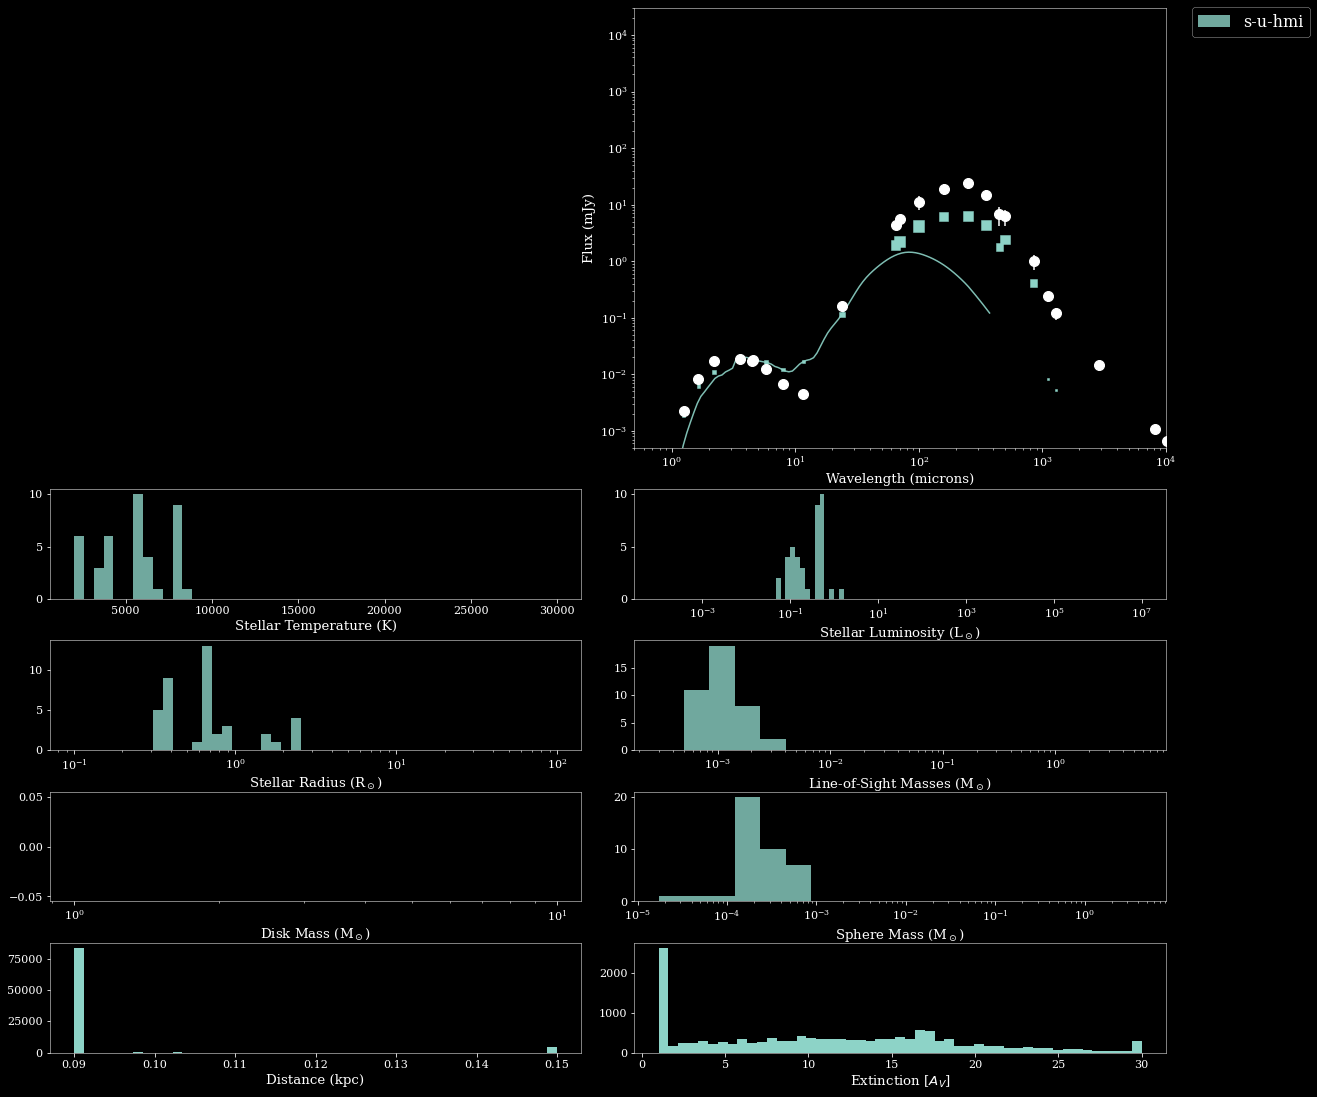

In [36]:
fit = fits['s-u-hmi']
plot_fit({'s-u-hmi': fit}, ['s-u-hmi'], chi2limit=1000,)

In [15]:
okgeo = []
for geom in geometries:
    print(f"{geom}: {np.nanmin(fits[geom].chi2):12.1f}")
    if np.nanmin(fits[geom].chi2) < 1000:
        okgeo.append(geom)

s---s-i:      54396.2
s---smi:      26106.6
sp--s-i:        734.7
sp--h-i:       1020.7
s---smi:      26106.6
s-p-smi:       9901.7
s-p-hmi:       2688.0
s-pbsmi:        659.1
s-pbhmi:        803.6
s-u-smi:       2102.1
s-u-hmi:       1931.5
s-ubsmi:       1685.5
spu-smi:       1048.8
spu-hmi:        931.5
spubsmi:        772.9
spubhmi:        470.5


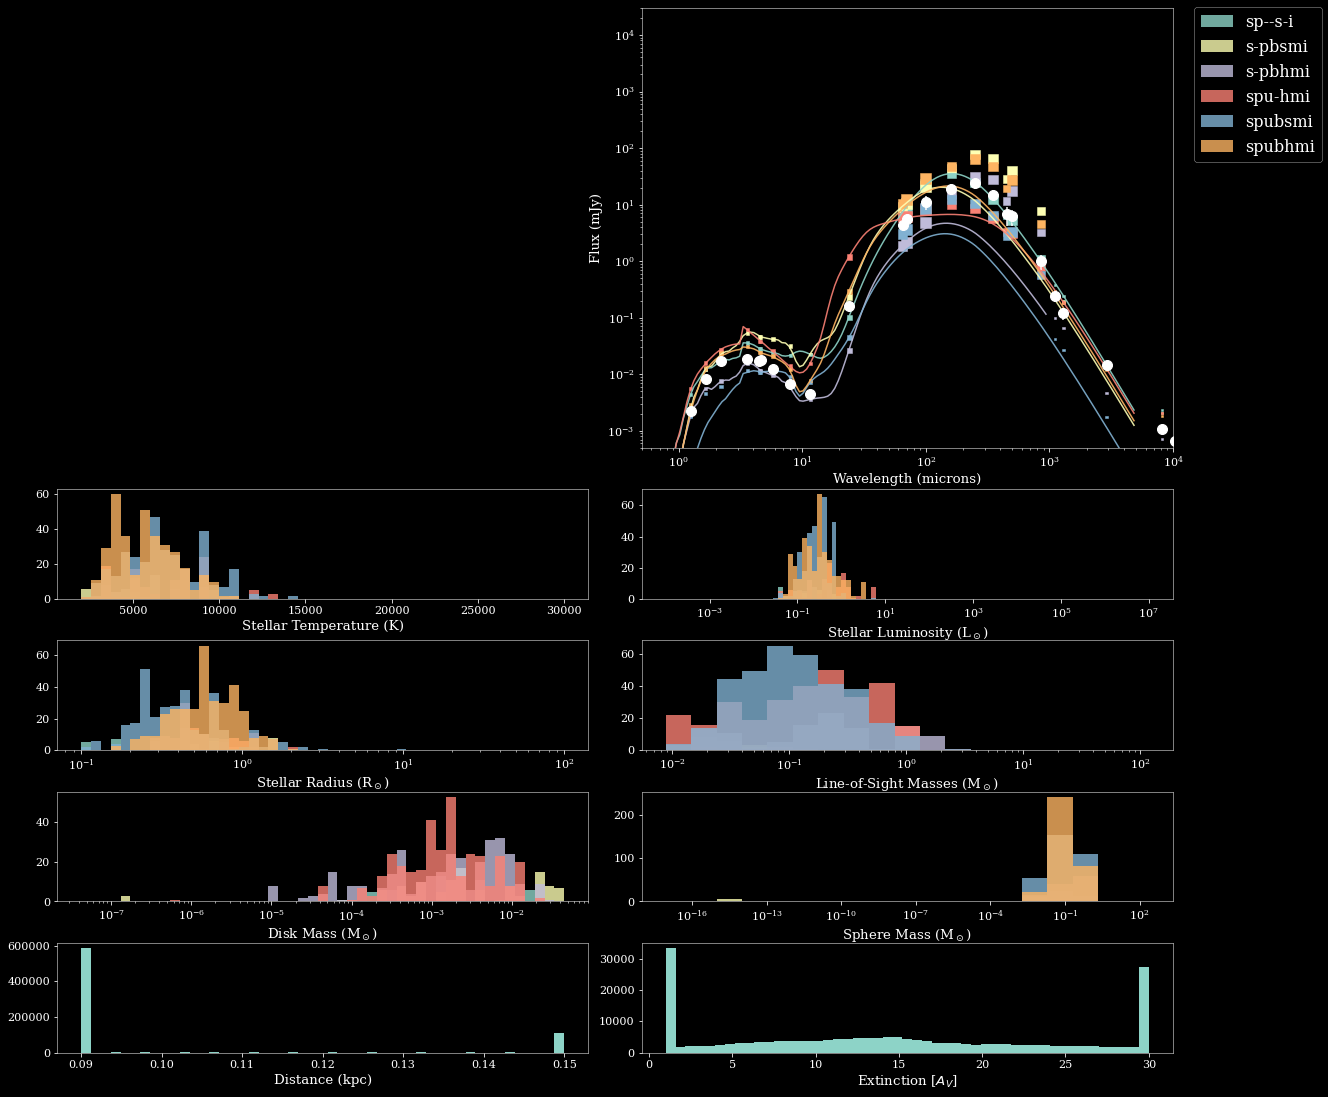

In [37]:
plot_fit(fits, okgeo, chi2limit=1000,)

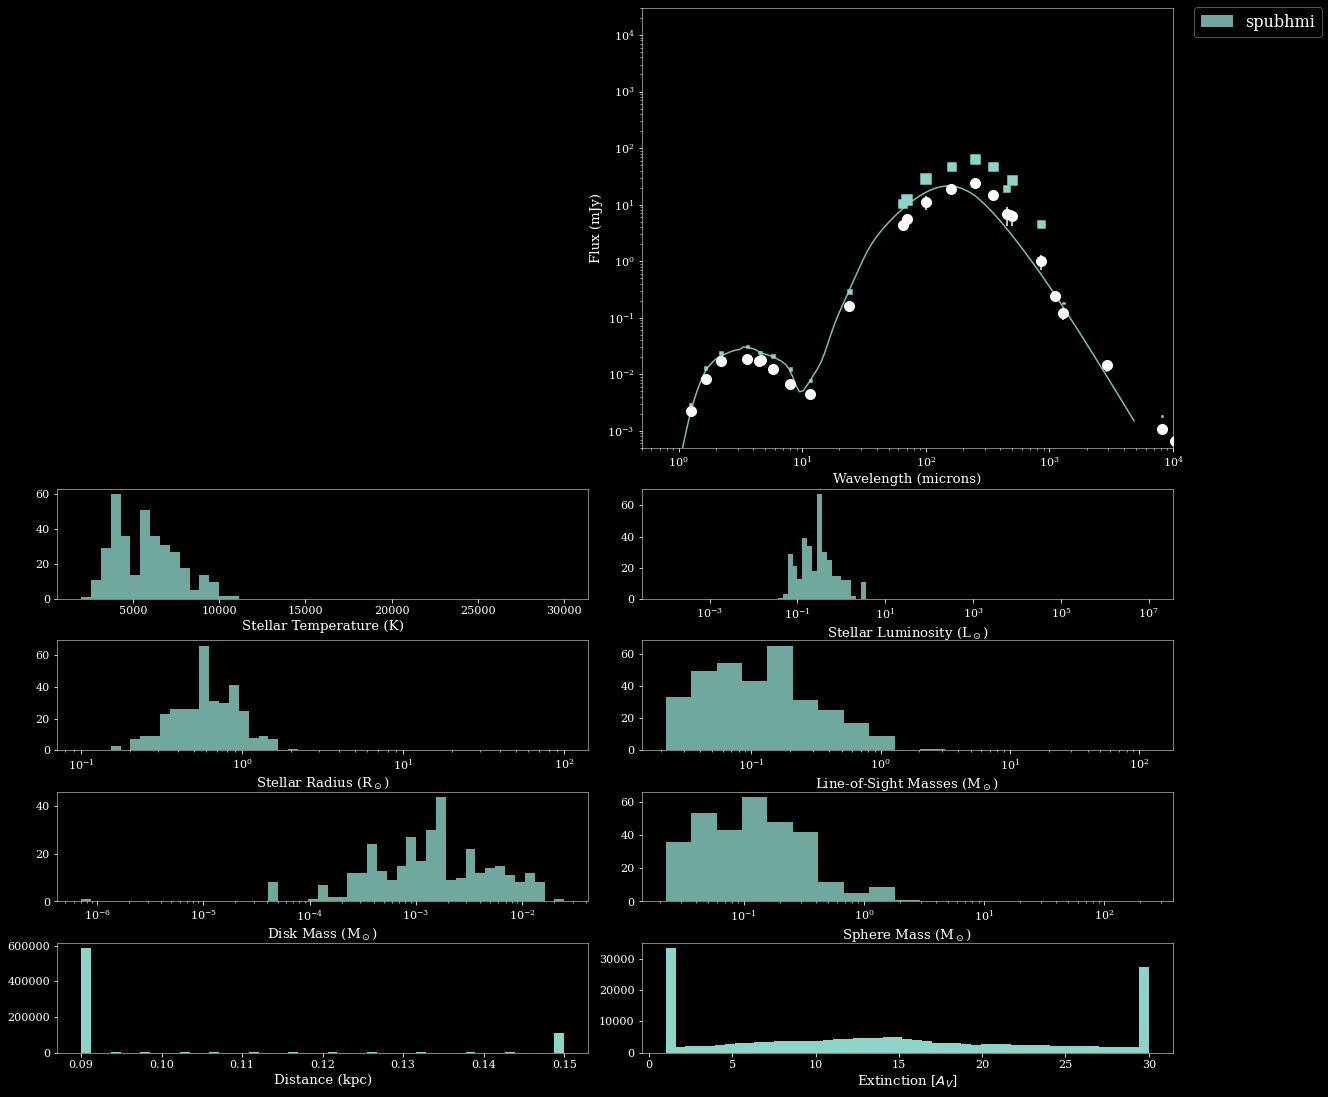

In [38]:
plot_fit(fits, ['spubhmi'], chi2limit=1000,)

In [33]:
geom = 'spubhmi'
chi2limit=1000
pars, data = datafunction(geom, chi2limit, fits)
fit = fits[geom]

(0.0, 5000.0)

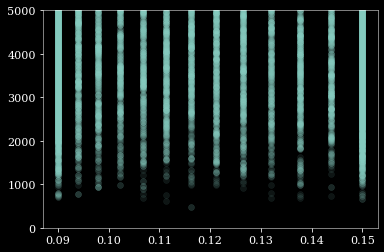

In [34]:
pl.scatter(10**fit.sc, fit.chi2, alpha=0.1)
pl.ylim(0,5000)

(0.0, 5000.0)

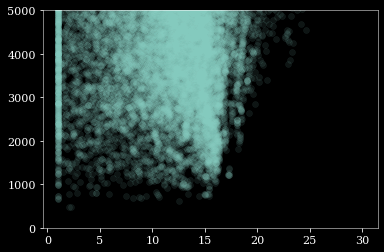

In [20]:
pl.scatter(fit.av, fit.chi2, alpha=0.1)
pl.ylim(0,5000)

In [21]:
pars['Sphere Masses'].shape

(720000, 20)

[]

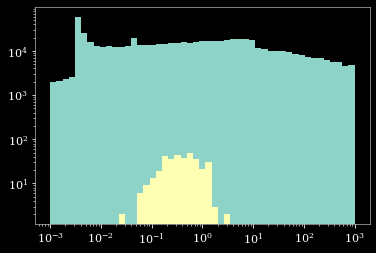

In [22]:
bins = np.logspace(-3,3)
pl.hist(pars['Sphere Masses'][:,9], bins=bins)
pl.hist(data['Sphere Masses'][:,9], bins=bins)

pl.loglog()

In [23]:
pars['star.radius'].max()

99.98